![](./images/banner.jpeg)
Photo by <a href="https://unsplash.com/@towfiqu999999?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Towfiqu barbhuiya</a> on <a href="https://unsplash.com/s/photos/customer-ratings?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
# I HATE this Product! Five Stars!
### Reducing Rating Inflation Using NLP
Author: Tom Chapman | [email](mailto:thomas.h.chapman@gmail.com) | [linkedin](https://www.linkedin.com/in/thomashchapman/) | [github](https://github.com/ThomasHChapman)

Most online marketplaces use 5-star product rating systems which are prone to rating inflation, obscuring product quality and customer sentiment. In addition to being problematic for the consumer, rating inflation makes it difficult for sellers to parse customer feedback and understand how their products are being received by the public. My project uses natural language processing to train a model on review sentiment so that it can be used to accurately classify customer reviews based on their content.


## Business Understanding
Since their inception, online marketplaces have fundamentally shifted how consumers shop. With a near limitless number of products and services available online, it has never been easier to avoid the hassle of brick-and-mortar stores. However, identifying which products or services are high-quality has become increasingly difficult. The popularity of the 5-star rating scale has led to a number of well-documented challenges. [Harvard Business Review](https://hbr.org/2019/07/the-problems-with-5-star-rating-systems-and-how-to-fix-them) summed these challenges up nicely as follows:

- There is little incentive for consumers to provide truthful feedback, meaning that extreme experiences (whether positive or negative) are much more likely to lead a consumer to leave a review.
- Compounding the lack of incentive for truth, 5-star rating scales are prone to grade inflation. There is no correlation between the star-rating and the sentiment the user expresses in a review. It's possible (and surprisingly common) for a user to hate a product, excoriate it in a review, and then rate it 5-stars. This leads to inflated ratings, and makes it harder for the consumer to understand the meaning behind varied product ratings. How much better is a product with a 4.7 star rating than a 4.5 star average rating?
My model is intended to help address rating inflation by classifying user feedback as positive or negative based on its content.

Amazon is the largest online marketplace currently in existence, and its challenges with rating inflation are [common knowledge](https://www.nytimes.com/2021/06/18/technology/amazon-reviews.html). However, any marketplace that uses a five-star rating system (Google Play, Apple App Store, Chewy, Wal-mart, Etsy, Rakuten, etc.) can utilize my model to reclassify user reviews into positive or negative polarity. Offering customers a clearer display of product quality allows customers to make more informed purchases, and should drive improved satisfaction. It should also help mitigate poor quality or scam sellers inherently, as poor reviews are less likely to be drowned out by inflated ratings.

The tool is also useful for sellers that want to move away from Amazon or implement their own storefront. By implementing my algorithm in a newly-created storefront, sellers can mostly automate the classification of consumer feedback and derive a more accurate understanding of how their products or services are being received. On average, Amazon sellers pay the website about 15% of their sale price on each item sold. There's no question the visibility and customer reach that Amazon provides is valuable, but 15% is an extremely hefty cost for small companies. For certain product categories, the cost per item can range as high as 45%, an enormous amount to pay simply for the storefront component of the site.

In [68]:
# Package Imports
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

import requests
import warnings
warnings.filterwarnings('ignore')

In [69]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/tom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Understanding
The data used for training our models is a publicly-available dataset hosted by Kaggle. Users with a Kaggle account and API token already configued can execute the next cell to download the data directly. 

Users without a Kaggle account or that just want to access the data can download it from the [source page](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews?select=amazon_review_polarity_csv.tgz).

The dataset is a subset of the Stanford Network Analysis Project (SNAP), which contains approximately 34 million Amazon reviews collected over a 13 year period. Our dataset consists of 1.8 million training samples in each polarity (positive or negative) and 200,000 validation samples in each polarity. The subset was created by labelling reviews that assigned a 1-2 star rating to the negative polarity, and reviews with a 4-5 star rating to the positive polarity. Ratings that gave 3 stars were omitted entirely.

Because my goal is to train a classifier that will generalize well across different kinds of products, I chose a dataset that did not specialize in any one category. My hope is that this choice will drive greater accuracy on both Amazon reviews and reviews from other data sources.

### Reproduction Instructions
To replicate the environment used for this project, follow the below steps. If you run into any trouble with this process, please reference the [Anaconda Documentation]((https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html)) for managing environments.
1. Download the [environment.yml](environment/environment.yml) file
2. Before launching the notebook, execute the below lines of code from the folder containing the environment.yml file:
- conda env create -f environment.yml
- conda activate rc-env
- python -m ipykernel install --user --name rc-env --display-name rc-environment

In [70]:
# Users with a Kaggle account & API token can run this cell to download the data directly.
# import kaggle
# kaggle datasets download -d kritanjalijain/amazon-reviews

In [71]:
# Read training data & assign column names
df = pd.read_csv('./large_data/train.csv', names=['sentiment', 'title', 'text'])
df.head()

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   text       object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [73]:
# Check for NaNs - Unimportant because we will not use the title column.
df.isna().sum()

sentiment     0
title        77
text          0
dtype: int64

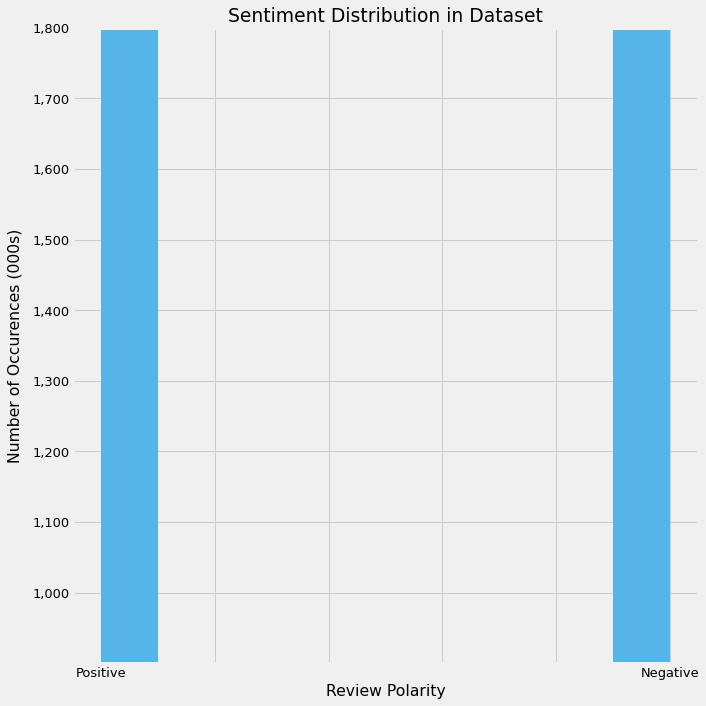

In [78]:
# Visualize sentiment frequency within the dataset
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 13})

fig, ax = plt.subplots(figsize=(10,10))
plt.axis([None, None, .9, 1.8])
plt.hist(df['sentiment'], color=[86/255,180/255,233/255])
ax.set_title('Sentiment Distribution in Dataset')
ax.set_ylabel('Number of Occurences (000s)',labelpad=10)
ax.set_xlabel('Review Polarity')
ax.set_xticklabels(labels = [None, 'Positive', None, None, None, None, 'Negative']);
ax.set_yticklabels(labels = [None, '1,000', '1,100', '1,200', '1,300', '1,400', '1,500', '1,600', '1,700', '1,800']);
plt.tight_layout()
plt.savefig('./images/sent_dist_final.png', transparent=False, dpi=500)

As expected, the data is near-perfectly distributed between the two sentiment classes.

# Data Preprocessing

Preprocessing is a critical piece of any NLP project.  They appear in order below, and perform the following tasks:

**get_wordnet_pos** -- Translates the part of speech tags assigned by nltk into wordnet tags that can be utilized by the lemmatizer.

**prepare_text** -- Main cleaner function. Performs the following tasks:
- Performs tokenization using a defined regular expression. By default the expression is words of any length that start with a capital or lowercase letter, and end with a lowercase letter.
- Converts all text to lowercase.
- Removes stopwords.
- Performs part of speech tagging and lemmatizes words.
- Returns a string of tokens.

**ngram_creator** -- Creates a list of tuples containing all possible n-grams in a text, where n is specified at runtime.

**visualize_top_n** -- Creates a dictionary of the n most common words in a FrequencyDistribution object, and plots a bar graph of their frequency.

**sw_finder** -- Returns a list of common words between two FrequencyDistribution Objects

## Helper Functions
Given the large size of the dataset, I created several helper functions to facilitate efficient text cleaning outside of the model pipelines prepared in the [modeling notebook](modeling_nb.ipynb).

In [8]:
# POS-Tag Translator

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk part of speech tags to wordnet tags that can be used by the lemmatizer.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
# Text Cleaner Function

def prepare_text(text, sw=stopwords.words('english'), regex_pattern = "([a-zA-Z]+(?:'[a-z]+)?)"):
    """
    Tokenize, standardize case, remove punctuation, perform part of speech tagging
    and lemmatize text from string.
    
    By default, tokenization is performed using a regular expression that grabs words 
    that begin with a capital or lowercase letter and end with a lowercase letter.
    """
    # Identify hyperlinks in the subject data & strip them out
    # Credit to Prajwal @ https://gitlab.com/praj88/twitter-analytics/blob/master/scripts/twitter-analytics.ipynb
    isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)
    text = isURL.sub("", text)
    
    # Tokenize words based on the regular expression stored in regex_pattern
    tokenizer = RegexpTokenizer(regex_pattern)
    tokens = tokenizer.tokenize(text)
    
    # Convert tokens to lowercase and remove words in the stop_list variable
    tokens = [token.lower() for token in tokens if token.lower() not in sw]
    
    # Perform part of speech tagging
    tokens_tagged = pos_tag(tokens)
    tokens_tagged = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Perform lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word[0], word[1]) for word in tokens_tagged]
    
    # Return a string consisting of all tokens
    return ' '.join(tokens)

In [10]:
# Function to convert prepared text into n-grams.

def ngram_creator(text, n):
    """
    Return a list of all possible n-grams from the specified text.
    """
    return list(ngrams(text.split(), n))

In [19]:
# Visualization Function to plot the n most common words in a frequency distribution object

def visualize_top_n(freq_dist, title, n=10):
    """
    Create a dictionary of the n most common words in a frequency distribution and plot a bar
    graph illustrating how many times those words appear in the frequency distribution object.
    """
    plt.style.use('fivethirtyeight')
    plt.rcParams.update({'font.size': 13})
        
    # Extract data for plotting
    top_n = list(zip(*freq_dist.most_common(n)))
    tokens = top_n[0]
    counts = top_n[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    
    # Save png of image to images folder using title as filename
    plt.savefig(f'./images/{title}', dpi=500, facecolor='auto')

In [12]:
# Function to identify common words in positive, negative reviews.

def sw_finder(fd1, fd2, n=10):
    """
    Intake two frequency distribution objects and return a list of n words
    that appear in both objects.
    """
    return list(dict(fd1.most_common(n)).keys() & dict(fd2.most_common(n)).keys())

## Data Cleaning
I began the cleaning process by testing the cleaner function on a single cell. It appears to be working correctly, so I moved on to create a new column called 'text_cleaned' to hold the results of the cleaning function. I then called the ngram_creator function on that cleaned text to create new columns that store bi-grams and tri-grams for each review. Finally, I checked for any instances of failure by the cleaning function to determine whether additional steps were needed. As it turned out, the cleaning function performed well and there were no instances of missing cleaned reviews.

In [13]:
# Test cleaner function on one row
sample_row = prepare_text(df['text'][0])
print(sample_row)

# Print original text for inspection
df['text'][0]

sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play best music back away crude keyboarding take fresh step grate guitar soulful orchestra would impress anyone care listen


'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [14]:
# Apply helper function to 'text' column and store the output in a new column
df['text_cleaned'] = df['text'].apply(prepare_text)

# Create & store bi-grams in a new column
df['bigrams'] = df['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df['trigrams'] = df['text_cleaned'].apply(ngram_creator, n=3)

In [15]:
# Check for reviews where the cleaning function failed & display them
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment        0
title           77
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [16]:
# Create new dataframe with cleaned text, sentiment and n-grams, save to csv.
df.to_csv('large_data/train_cleaned.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

In [17]:
# Display the first five rows for visual inspection
df.head()

,sentiment,title,text,text_cleaned,bigrams,trigrams
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,sound track beautiful paint senery mind well w...,"[(sound, track), (track, beautiful), (beautifu...","[(sound, track, beautiful), (track, beautiful,..."
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,i'm reading lot review say best game soundtrac...,"[(i'm, reading), (reading, lot), (lot, review)...","[(i'm, reading, lot), (reading, lot, review), ..."
2,2,Amazing!,This soundtrack is my favorite music of all ti...,soundtrack favorite music time hand intense sa...,"[(soundtrack, favorite), (favorite, music), (m...","[(soundtrack, favorite, music), (favorite, mus..."
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,truly like soundtrack enjoy video game music p...,"[(truly, like), (like, soundtrack), (soundtrac...","[(truly, like, soundtrack), (like, soundtrack,..."
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",played game know divine music every single son...,"[(played, game), (game, know), (know, divine),...","[(played, game, know), (game, know, divine), (..."


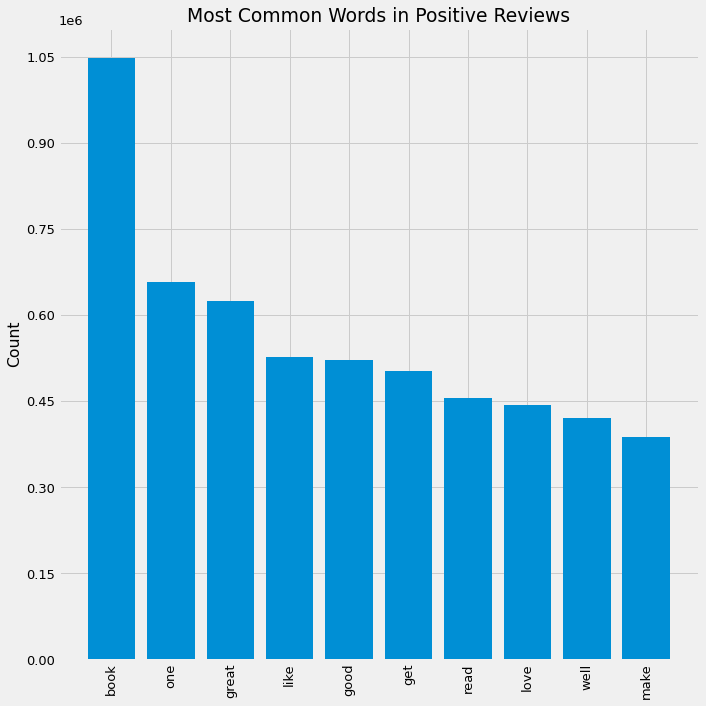

In [20]:
# Ten most common words appearing in positive reviews
pos_freq_dist = FreqDist(df['text_cleaned'].str.split().explode().loc[df['sentiment'] == 2])
visualize_top_n(pos_freq_dist, 'Most Common Words in Positive Reviews', 10)

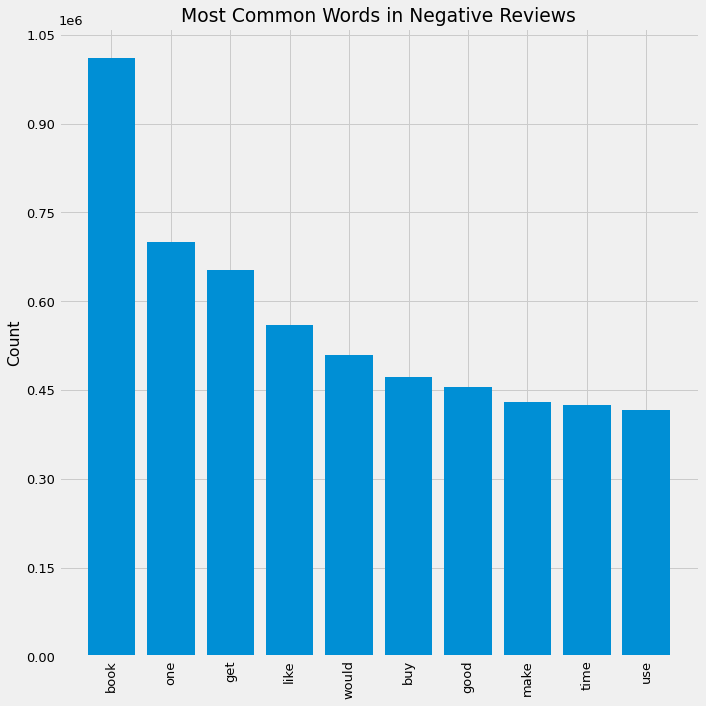

In [21]:
# Ten most common words appearing in negative reviews
neg_freq_dist = FreqDist(df['text_cleaned'].str.split().explode().loc[df['sentiment'] == 1])
visualize_top_n(neg_freq_dist, 'Most Common Words in Negative Reviews', 10)

### Identify and Remove Custom Stopwords
The following section will be focused on identifying the most common words in reviews of each sentiment, and finding where these lists intersect. Words that appear frequently in both sentiments begin to lose their meaning, and we will attempt to address this by removing any words that are among the 10 most common in both sentiments. I chose 10 words as the cutoff because there seems to be a breakpoint at 10 words where the same words do not appear in both lists and are not ordered the same in terms of commonality. I created a custom stopwords list using the sw_finder function and extended the default stopwords list to include these common words. I then re-ran the cleaning function and saved the results to a .csv for use in the modeling notebook.

In [22]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
train_sw = sw_finder(neg_freq_dist, pos_freq_dist, 10)
train_sw

['one', 'good', 'book', 'get', 'like', 'make']

In [23]:
# Extend stop_list to include the elements of custom_sw
train_sw.extend(stopwords.words('english'))
train_sw

['one',
 'good',
 'book',
 'get',
 'like',
 'make',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'whe

In [24]:
# Apply helper function to 'text' column and store the output in a new column
df['text_cleaned'] = df['text'].apply(prepare_text, sw=train_sw)

# Create & store bi-grams in a new column
df['bigrams'] = df['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df['trigrams'] = df['text_cleaned'].apply(ngram_creator, n=3)

In [25]:
# Identify reviews where the cleaning function failed & display them
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment        0
title           77
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [26]:
# Create new dataframe with cleaned text and sentiment, save to csv.
df.to_csv('./large_data/train_cleaned_10sw.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

## Transform Test Data
For the test data, I followed the same cleaning process and utilized the same functions as on the train data. Although the specific stop words might vary, I followed the same procedure with custom words and removed any words that appeared in the 10 most common words in each sentiment. I saved off .csv files with and without the use of custom stopword filtering to see which will perform better in the [modeling notebook](modeling_nb.ipynb).

In [27]:
# Read in valdiation data
df_test = pd.read_csv('./large_data/test.csv', names=['sentiment', 'title', 'text']) 
df_test.head()

,sentiment,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  400000 non-null  int64 
 1   title      399990 non-null  object
 2   text       400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [29]:
# Check for NaNs - Unimportant because we will not use the title column.
df_test.isna().sum()

sentiment     0
title        10
text          0
dtype: int64

In [30]:
# Apply cleaning function to the validation set
df_test['text_cleaned'] = df_test['text'].apply(prepare_text)

# Create & store trigrams in a new column
df_test['bigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_test['trigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=3)

In [31]:
df_test.head()

,sentiment,title,text,text_cleaned,bigrams,trigrams
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,lovely pat one great voice generation listen c...,"[(lovely, pat), (pat, one), (one, great), (gre...","[(lovely, pat, one), (pat, one, great), (one, ..."
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,despite fact play small portion game music hea...,"[(despite, fact), (fact, play), (play, small),...","[(despite, fact, play), (fact, play, small), (..."
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,bought charger jul work ok design nice conveni...,"[(bought, charger), (charger, jul), (jul, work...","[(bought, charger, jul), (charger, jul, work),..."
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,check maha energy's website powerex mh c f cha...,"[(check, maha), (maha, energy's), (energy's, w...","[(check, maha, energy's), (maha, energy's, web..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,review quite bit combo player hesitant due unf...,"[(review, quite), (quite, bit), (bit, combo), ...","[(review, quite, bit), (quite, bit, combo), (b..."


In [32]:
# Identify reviews where the cleaning function failed & display them
print(df_test.isna().sum())
df_test[df_test['text_cleaned'].isna()]

sentiment        0
title           10
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [33]:
# Save validation data to a new CSV file
df_test.to_csv('./large_data/test_cleaned.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

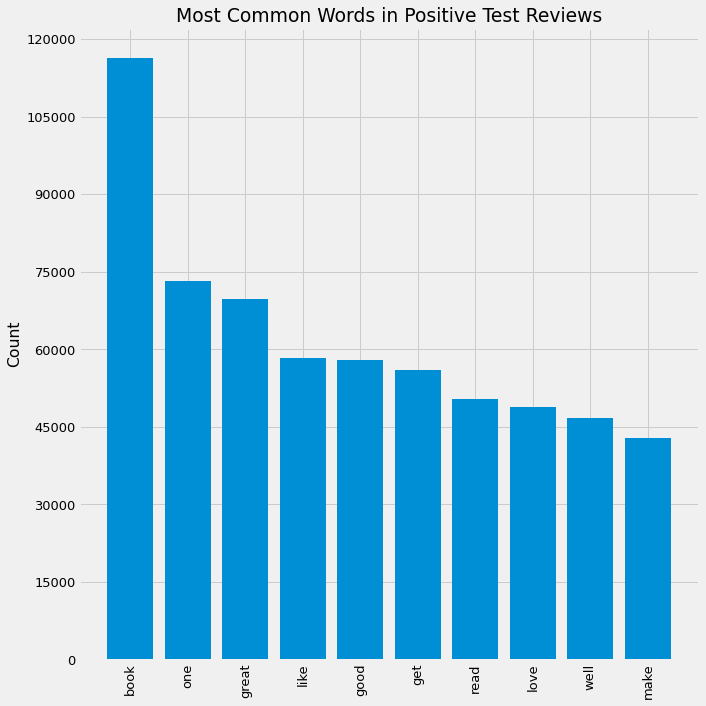

In [34]:
# Ten most common words appearing in positive test reviews
pos_test_dist = FreqDist(df_test['text_cleaned'].str.split().explode().loc[df_test['sentiment'] == 2])
visualize_top_n(pos_test_dist, 'Most Common Words in Positive Test Reviews', 10)

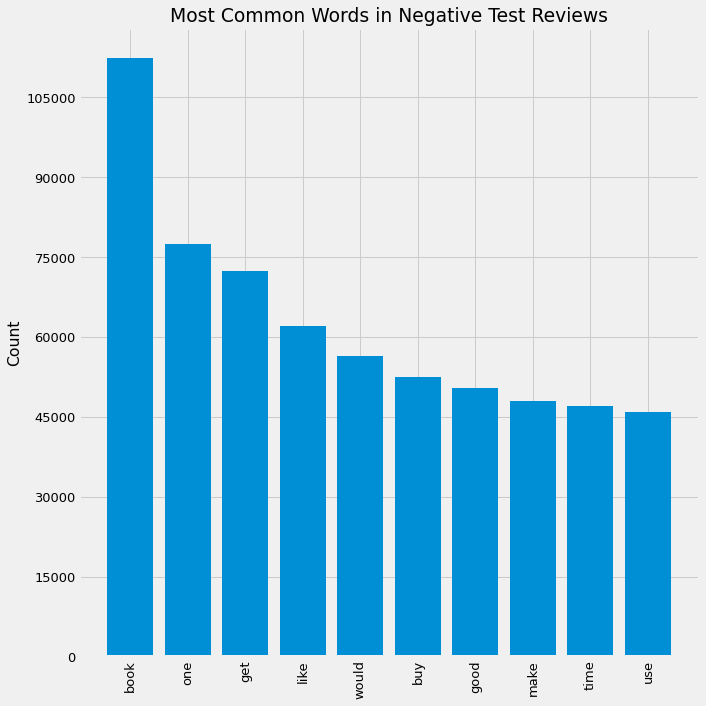

In [35]:
# Ten most common words appearing in negative reviews
neg_test_dist = FreqDist(df_test['text_cleaned'].str.split().explode().loc[df_test['sentiment'] == 1])
visualize_top_n(neg_test_dist, 'Most Common Words in Negative Test Reviews', 10)

In [36]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
test_sw = sw_finder(neg_test_dist, pos_test_dist, 10)
test_sw

['one', 'good', 'book', 'get', 'like', 'make']

In [37]:
# Extend test_sw to include custom stop words from test data.
test_sw.extend(stopwords.words("english")) 
test_sw

['one',
 'good',
 'book',
 'get',
 'like',
 'make',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'whe

In [38]:
# Re-apply cleaning function to 'text' column using identified stopwords 
df_test['text_cleaned'] = df_test['text'].apply(prepare_text, sw=test_sw)

# Create & store bi-grams in a new column
df_test['bigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_test['trigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=3)

In [39]:
# Identify reviews where the cleaning function failed & display them
print(df_test.isna().sum())
df_test[df_test['text_cleaned'].isna()]

sentiment        0
title           10
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [40]:
# Create new dataframe with cleaned text inclusive of custom sw and sentiment, save to csv.
df_test.to_csv('./large_data/test_cleaned_10sw.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

## Reddit Product Reveiws
As part of the project, I wanted to see how my cleaning process and final model would perform on real-world data. This section covers how I extracted 100 posts from Reddit's r/productreviews subreddit and cleaned the resulting extract for use in our model.

Reddit's API requires users to create an account and register their application in order to obtain an oauth token. This process is fairly simple, and can be completed in a matter of minutes [at this link](https://www.reddit.com/prefs/apps). James Briggs has an excellent tutorial available on [Medium](https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c), which I followed to get access to the API. **NOTE:** James's example code involves hard coding the API credentials, which is an insecure practice for a notebook that will be stored in a public repository. If you have any intention of storing this notebook in a public repository, please use safe coding practices to protect your API credentials from misuse. Scott Harden has published a [simple blog post](https://swharden.com/blog/2021-05-15-python-credentials/) which outlines several options and their advantages and drawbacks. 

This notebook is set up to read the necessary API credentials from a text file stored in ./creds/reddit.txt. The creds folder is omitted from my repository for security reasons, so the following bits of code may not function without some additional work. To replicate this process, simply create a creds directory containing a blank reddit.txt file, and paste your application's personal use token, secret token, username and password on the first four lines of reddit.txt. Alternatively, you can create your own credentials file in a location of your choosing and modify the file path in the following cell to point to where it is stored.

Not to worry--the cleaned Reddit data will be uploaded to the [data](./data) folder so that the modeling process can be replicated.

In [41]:
# Read necessary API credentials from reddit.txt file.

with open("./creds/reddit.txt") as f:
    lines = f.readlines()
    client_id = lines[0].strip()
    secret_token = lines[1].strip()
    username = lines[2].strip()
    password = lines[3].strip()

In [44]:
# Credit to James Briggs for the starter code used to create our API session.
# https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c)

# Define auth type, inclusive of my Reddit script's API tokens
auth = requests.auth.HTTPBasicAuth(client_id, secret_token)

# Define my reddit account's username and password to be used in token generation
data = {'grant_type': 'password',
        'username': username,
        'password': password}

# Define my application's header information which gives Reddit a brief description of the app
headers = {'User-Agent': 'review-finder/0.0.1'}

# Send request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token', 
                    auth = auth, data = data, headers = headers)

# Convert response to JSON and extract the access_token value
TOKEN = res.json()['access_token']

# Add authorization to our headers directory
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# While the OAuth token is valid (~2 hours), we can add headers=headers to API calls
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

Now we're ready to make our first call to extract post data. By default, reddit's API returns 25 posts with each call unless the limit parameter is increased. We will increase this to 100 posts, and execute our first call.

In [45]:
# Make an API call using a limit parameter of 100
req_new = requests.get("https://oauth.reddit.com/r/ProductReviews/new",
                   headers=headers,
                   params={'limit': '100'})     

In [46]:
# Instantiate a new dataframe to hold the results of our calls
df_red_new = pd.DataFrame()

# Loop over the posts in the response
for post in req_new.json()['data']['children']:
    
    # Append relevant post data to dataframe
    df_red_new = df_red_new.append({
        'subreddit': post['data']['subreddit'],
        'title': post['data']['title'],
        'selftext': post['data']['selftext']
        }, 
        ignore_index=True)  

# Visually inspect the dataframe
df_red_new

,subreddit,title,selftext
0,ProductReviews,Kingston DataTraveler Exodia 32GB USB 3.2 Flas...,&amp;#x200B;\n\nhttps://preview.redd.it/6l2ty5...
1,ProductReviews,Farmer Leaf Huey Wa Big Trees Tea Review - Pro...,
2,ProductReviews,Cooking boxed cake mix in the microwave review,
3,ProductReviews,"2014 Hai Lang Hao ""Glorious Years"" Bu Lang Raw...",
4,ProductReviews,Paper VS Styrofoam airplanes,
...,...,...,...
95,ProductReviews,BETTER BUSINESS FOR A BETTER TOMORROW,
96,ProductReviews,$10 MOUSEPAD!,
97,ProductReviews,Reviewing The 6 Best Power Racks For Your Home...,
98,ProductReviews,Neewer Camera Monitor: It comes with a battery!,


In [47]:
# Save Reviews to .csv prior to cleaning.
df_red_new.to_csv('./data/reddit_new.csv')

When we visually inspected the dataframe above, we noted that many of the selftext fields were blank. This can happen if a user populates the "link" field in a reddit post and does not add any text to their post. For our purposes, we will drop these posts since we don't have an easy way to get the review text from the linked pages.

In [48]:
# Convert posts with no text to show NaN so they can be dropped.
df_red_new.replace(r'^\s*$', np.NaN, regex=True, inplace=True)
df_red_new.dropna(inplace=True)
df_red_new

,subreddit,title,selftext
0,ProductReviews,Kingston DataTraveler Exodia 32GB USB 3.2 Flas...,&amp;#x200B;\n\nhttps://preview.redd.it/6l2ty5...
7,ProductReviews,Brita Flow Water Filter Tank Review | Trusted ...,&amp;#x200B;\n\nhttps://preview.redd.it/rcxdqi...
19,ProductReviews,SPRAY ON DEODORANT WORTH IT? - Degree MotionSe...,Degree MotionSense Antiperspirant Deodorant Dr...
26,ProductReviews,Do not buy from PortoProjector,I don't think any negative review I write on [...
28,ProductReviews,12 Smart LED Lamps to Buy This Year!,[https://estheticselections.com/12-smart-led-l...
30,ProductReviews,Anker PowerWave Pad Review,https://www.reddit.com/user/tht_prelude_guy/co...
32,ProductReviews,My home gym. A little tour of my space and som...,[https://youtu.be/eGJyt25mPqU](https://youtu.b...
33,ProductReviews,Herr's Barbecue Cheese Puff Review,[https://youtu.be/CavIcNRyrZk](https://youtu.b...
34,ProductReviews,An unbiased review of FlexTrim's 3/4 round fle...,[https://youtu.be/RGubqwaMKYM](https://youtu.b...
35,ProductReviews,My review of a reverse osmosis filtration syst...,[https://youtu.be/JC6Zgx0-oj8](https://youtu.b...


From here, we will apply the same text-cleaning and n-gram creation functions to the Reddit text that we used for our Amazon data. We'll also re-check the data for posts with blank "text_cleaned" fields. In our case, this appears to happen when users paste a link to their video or text review and no other text in the text box. Reddit renders the video so it can be easily accessed by anyone that visits the subreddit, but we are left without any usable review text to parse. Our cleaning process will vary slightly from the Amazon data for reddit posts--because we do not have a large amount of labeled data, we cannot create custom stopwords for reddit posts. Instead we will use the default English stop words specified by nltk.

After the cleaning functions are applied, we are left with 14 of our original 99 posts to pass to our model. This isn't a huge population, but should provide some anecdotal examples of whether or not the model is correctly classifying reviews based on our inspection of the text. That process is covered in the [modeling notebook](./modeling_nb.ipynb).

In [49]:
# Apply cleaning function to the reddit data
df_red_new['text_cleaned'] = df_red_new['selftext'].apply(prepare_text)

# Create & store trigrams in a new column
df_red_new['bigrams'] = df_red_new['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_red_new['trigrams'] = df_red_new['text_cleaned'].apply(ngram_creator, n=3)

# Convert posts with no text to show NaN so they can be dropped & drop them.
df_red_new.replace(r'^\s*$', np.NaN, regex=True, inplace=True)
df_red_new.dropna(inplace=True)

# Reset dataframe index after dropping instances of blank posts
df_red_new.reset_index(drop=True, inplace=True)

# Confirm we have no missing values
df_red_new.isna().sum()

subreddit       0
title           0
selftext        0
text_cleaned    0
bigrams         0
trigrams        0
dtype: int64

In [50]:
# Visually Inspect the Results
df_red_new

,subreddit,title,selftext,text_cleaned,bigrams,trigrams
0,ProductReviews,Kingston DataTraveler Exodia 32GB USB 3.2 Flas...,&amp;#x200B;\n\nhttps://preview.redd.it/6l2ty5...,amp x b kingston datatraveler exodia affordabl...,"[(amp, x), (x, b), (b, kingston), (kingston, d...","[(amp, x, b), (x, b, kingston), (b, kingston, ..."
1,ProductReviews,Brita Flow Water Filter Tank Review | Trusted ...,&amp;#x200B;\n\nhttps://preview.redd.it/rcxdqi...,amp x b brita flow water tank design filter ta...,"[(amp, x), (x, b), (b, brita), (brita, flow), ...","[(amp, x, b), (x, b, brita), (b, brita, flow),..."
2,ProductReviews,SPRAY ON DEODORANT WORTH IT? - Degree MotionSe...,Degree MotionSense Antiperspirant Deodorant Dr...,degree motionsense antiperspirant deodorant dr...,"[(degree, motionsense), (motionsense, antipers...","[(degree, motionsense, antiperspirant), (motio..."
3,ProductReviews,Do not buy from PortoProjector,I don't think any negative review I write on [...,think negative review write site display i'll ...,"[(think, negative), (negative, review), (revie...","[(think, negative, review), (negative, review,..."
4,ProductReviews,Taotronics Active Noise Cancelling Headphone (...,I had a chance to use Taotronics' Active Noise...,chance use taotronics active noise cancel head...,"[(chance, use), (use, taotronics), (taotronics...","[(chance, use, taotronics), (use, taotronics, ..."
5,ProductReviews,US ONLY! Free!,We have free item for US only!\n\nNitrile Disp...,free item u nitrile disposable glove pcs inter...,"[(free, item), (item, u), (u, nitrile), (nitri...","[(free, item, u), (item, u, nitrile), (u, nitr..."
6,ProductReviews,I just launched a tech product review page on ...,I will review different tech products every we...,review different tech product every week join ...,"[(review, different), (different, tech), (tech...","[(review, different, tech), (different, tech, ..."
7,ProductReviews,"Best Muscle "" massage "" Guns in 2020 - Reviews",A percussion massager or massage gun is extre...,percussion massager massage gun extremely usef...,"[(percussion, massager), (massager, massage), ...","[(percussion, massager, massage), (massager, m..."
8,ProductReviews,Did Thymuskin hair-growth treatment give you a...,I have been using Thymuskin hair shampoo and s...,use thymuskin hair shampoo serum medium month ...,"[(use, thymuskin), (thymuskin, hair), (hair, s...","[(use, thymuskin, hair), (thymuskin, hair, sha..."
9,ProductReviews,Self-installed bluetooth in 15 yr old Scion in...,"I rarely review anything except books, and th...",rarely review anything except book excellent p...,"[(rarely, review), (review, anything), (anythi...","[(rarely, review, anything), (review, anything..."


In [51]:
# Create new dataframe with cleaned text inclusive of custom sw and sentiment, save to csv.
df_red_new.to_csv('./data/reddit_cleaned.csv')

### Testing Women's Fashion Data
As one final test of the model, we will need a labeled set of unseen data. For this purpose, I am utilizing [a dataset from Kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews) which contains 23,500 reviews of women's fashion items. Each product is rated on a scale from 1-5, so it should provide a reasonable test of my model's ability to make predictions on a more targeted category of reviews. This data will be used as a validation set in the [modeling notebook](modeling_nb.ipynb) to test the model's accuracy on unseen data.

To mimic my training data's preparation, I elected to drop all instances of "3" rated products. I considered these neutral for the purposes of the exercise and therefore it is not possible for my model to correctly (or incorrectly) predict them. Like many rating datasets, there is a class imbalance in favor of 5-star rated products, but this should not matter as it will not be used for model training. If anything, it demonstrates a common issue with consumer review data.

Finally, I generated a list of custom stopwords and removed them from the dataset to help the model better differentiate between positive and negative reviews.

In [52]:
# Read in the Data, using only the columns needed to evaluate using the final model.
df_fash = pd.read_csv('./large_data/Womens Clothing E-Commerce Reviews.csv', index_col=0, 
                      usecols = ['Clothing ID', 'Review Text', 'Rating'])

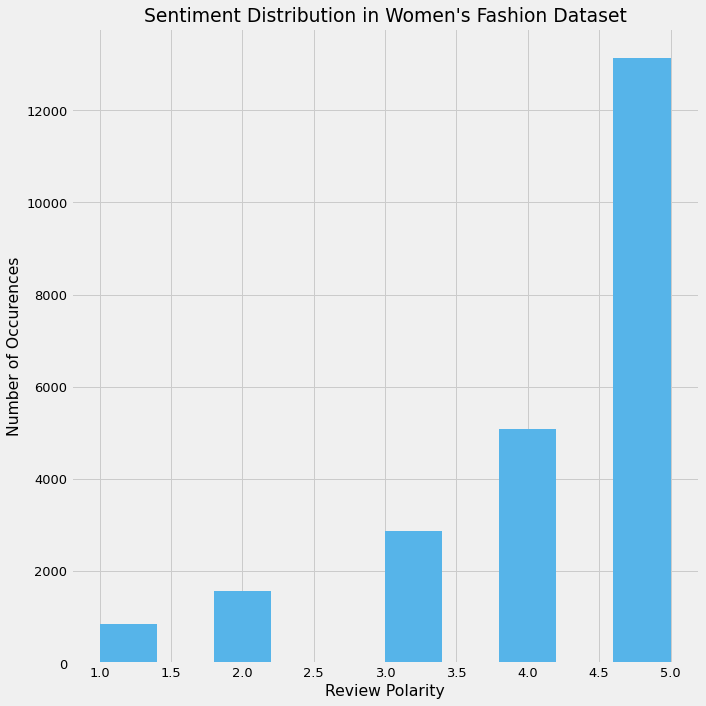

In [53]:
# Visualize sentiment frequency within the dataset
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 13})

fig, ax = plt.subplots(figsize=(10,10))

plt.hist(df_fash['Rating'], color=[86/255,180/255,233/255])
ax.set_title("Sentiment Distribution in Women's Fashion Dataset")
ax.set_ylabel('Number of Occurences')
ax.set_xlabel('Review Polarity')
plt.tight_layout();
#plt.savefig('../images/sent_dist_fashion.png', dpi=500, facecolor='auto')

In [54]:
# Drop reviews with a rating of 3.0
df_fash = df_fash[df_fash['Rating'] != 3]
df_fash['Rating'].value_counts()

5    13131
4     5077
2     1565
1      842
Name: Rating, dtype: int64

In [55]:
# Review info
df_fash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20615 entries, 767 to 1104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  19818 non-null  object
 1   Rating       20615 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


In [56]:
# Convert posts with no text to show NaN so they can be dropped & drop them.
df_fash.replace(r'^\s*$', np.NaN, regex=True, inplace=True)
df_fash.dropna(inplace=True)

# Reset dataframe index after dropping instances of blank posts
df_fash.reset_index(drop=True, inplace=True)

# Confirm we have no missing values
df_fash.isna().sum()

# Apply cleaning function to the reddit data
df_fash['text_cleaned'] = df_fash['Review Text'].apply(prepare_text)

# Create & store trigrams in a new column
df_fash['bigrams'] = df_fash['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_fash['trigrams'] = df_fash['text_cleaned'].apply(ngram_creator, n=3)

In [57]:
# Confirm no missing fields
df_fash.isna().sum()

Review Text     0
Rating          0
text_cleaned    0
bigrams         0
trigrams        0
dtype: int64

In [58]:
# Visually inspect header
df_fash.head()

,Review Text,Rating,text_cleaned,bigrams,trigrams
0,Absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable,"[(absolutely, wonderful), (wonderful, silky), ...","[(absolutely, wonderful, silky), (wonderful, s..."
1,Love this dress! it's sooo pretty. i happene...,5,love dress sooo pretty happen find store i'm g...,"[(love, dress), (dress, sooo), (sooo, pretty),...","[(love, dress, sooo), (dress, sooo, pretty), (..."
2,"I love, love, love this jumpsuit. it's fun, fl...",5,love love love jumpsuit fun flirty fabulous ev...,"[(love, love), (love, love), (love, jumpsuit),...","[(love, love, love), (love, love, jumpsuit), (..."
3,This shirt is very flattering to all due to th...,5,shirt flatter due adjustable front tie perfect...,"[(shirt, flatter), (flatter, due), (due, adjus...","[(shirt, flatter, due), (flatter, due, adjusta..."
4,"I love tracy reese dresses, but this one is no...",2,love tracy reese dress one petite foot tall us...,"[(love, tracy), (tracy, reese), (reese, dress)...","[(love, tracy, reese), (tracy, reese, dress), ..."


In [59]:
# Bin ratings into binary categories for use in final model
df_fash.loc[df_fash['Rating'].between(1, 2, 'both'), 'sentiment'] = 1
df_fash.loc[df_fash['Rating'].between(4, 5, 'both'), 'sentiment'] = 2
df_fash

,Review Text,Rating,text_cleaned,bigrams,trigrams,sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable,"[(absolutely, wonderful), (wonderful, silky), ...","[(absolutely, wonderful, silky), (wonderful, s...",2.0
1,Love this dress! it's sooo pretty. i happene...,5,love dress sooo pretty happen find store i'm g...,"[(love, dress), (dress, sooo), (sooo, pretty),...","[(love, dress, sooo), (dress, sooo, pretty), (...",2.0
2,"I love, love, love this jumpsuit. it's fun, fl...",5,love love love jumpsuit fun flirty fabulous ev...,"[(love, love), (love, love), (love, jumpsuit),...","[(love, love, love), (love, love, jumpsuit), (...",2.0
3,This shirt is very flattering to all due to th...,5,shirt flatter due adjustable front tie perfect...,"[(shirt, flatter), (flatter, due), (due, adjus...","[(shirt, flatter, due), (flatter, due, adjusta...",2.0
4,"I love tracy reese dresses, but this one is no...",2,love tracy reese dress one petite foot tall us...,"[(love, tracy), (tracy, reese), (reese, dress)...","[(love, tracy, reese), (tracy, reese, dress), ...",1.0
...,...,...,...,...,...,...
19813,I'm so impressed with the beautiful color comb...,4,i'm impress beautiful color combination embroi...,"[(i'm, impress), (impress, beautiful), (beauti...","[(i'm, impress, beautiful), (impress, beautifu...",2.0
19814,I was surprised at the positive reviews for th...,1,surprised positive review product terrible cut...,"[(surprised, positive), (positive, review), (r...","[(surprised, positive, review), (positive, rev...",1.0
19815,So i wasn't sure about ordering this skirt bec...,5,sure order skirt see person first i'm glad ski...,"[(sure, order), (order, skirt), (skirt, see), ...","[(sure, order, skirt), (order, skirt, see), (s...",2.0
19816,I was very happy to snag this dress at such a ...,5,happy snag dress great price easy slip flatter...,"[(happy, snag), (snag, dress), (dress, great),...","[(happy, snag, dress), (snag, dress, great), (...",2.0


In [60]:
# Save cleaned fashion data to .csv
df_fash.to_csv('./data/fashion_cleaned.csv')

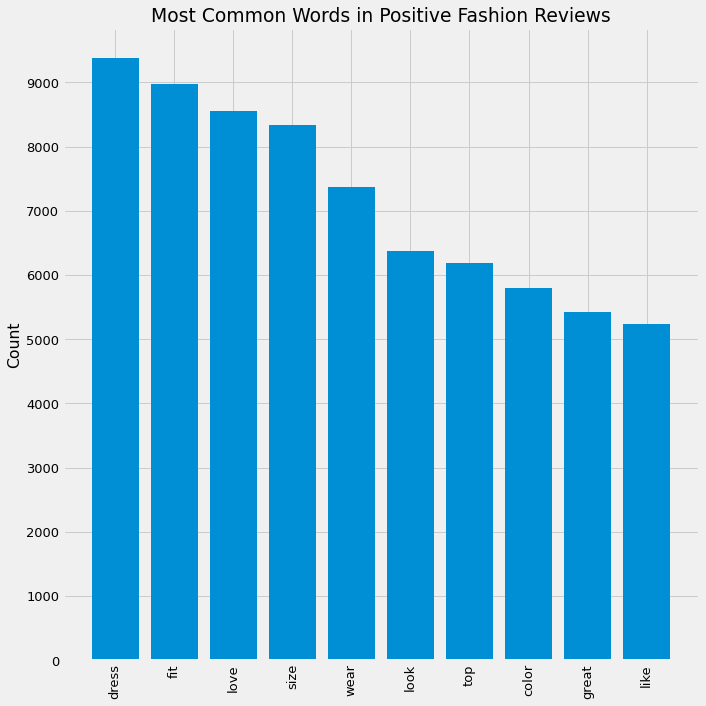

In [61]:
# Ten most common words appearing in positive fashion reviews
pos_fash_dist = FreqDist(df_fash['text_cleaned'].str.split().explode().loc[df_fash['sentiment'] == 2])
visualize_top_n(pos_fash_dist, 'Most Common Words in Positive Fashion Reviews', 10)

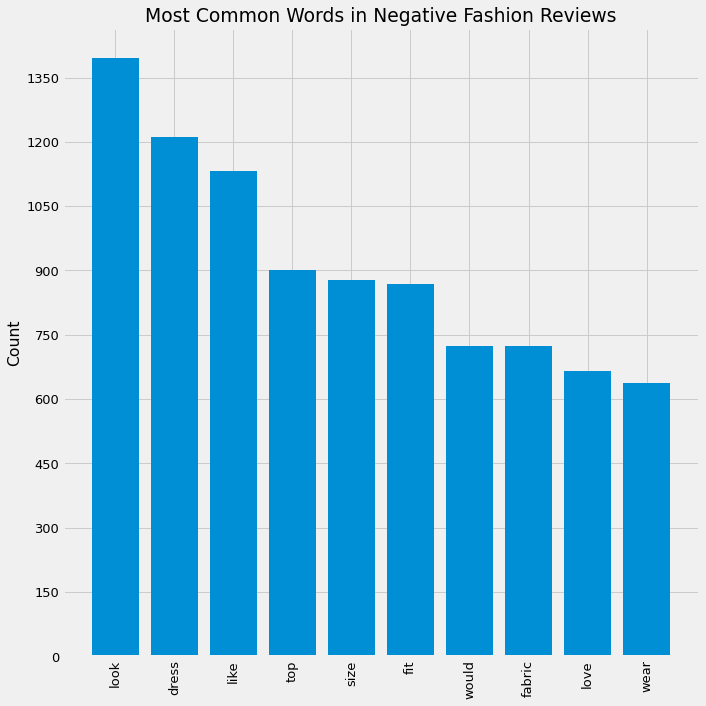

In [62]:
# Ten most common words appearing in positive fashion reviews
neg_fash_dist = FreqDist(df_fash['text_cleaned'].str.split().explode().loc[df_fash['sentiment'] == 1])
visualize_top_n(neg_fash_dist, 'Most Common Words in Negative Fashion Reviews', 10)

In [63]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
fash_sw = sw_finder(neg_fash_dist, pos_fash_dist, 10)
fash_sw

['look', 'love', 'size', 'dress', 'top', 'wear', 'like', 'fit']

In [64]:
# Extend test_sw to include custom stop words from test data.
fash_sw.extend(stopwords.words("english")) 
fash_sw

['look',
 'love',
 'size',
 'dress',
 'top',
 'wear',
 'like',
 'fit',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'the

In [65]:
# Apply cleaning function to the fashion data using custom stopwords
df_fash['text_cleaned'] = df_fash['Review Text'].apply(prepare_text, sw=fash_sw)

# Create & store trigrams in a new column
df_fash['bigrams'] = df_fash['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_fash['trigrams'] = df_fash['text_cleaned'].apply(ngram_creator, n=3)

# Convert posts with no text to show NaN so they can be dropped & drop them.
df_fash.replace(r'^\s*$', np.NaN, regex=True, inplace=True)
df_fash.dropna(inplace=True)

# Reset dataframe index after dropping instances of blank posts
df_fash.reset_index(drop=True, inplace=True)

# Confirm we have no missing values
df_fash.isna().sum()

Review Text     0
Rating          0
text_cleaned    0
bigrams         0
trigrams        0
sentiment       0
dtype: int64

In [66]:
# Save cleaned fashion data to .csv
df_fash.to_csv('./data/fashion_cleaned_10sw.csv')